# Treinando Redes Neurais Profundas

### Bibliotecas básicas

In [1]:
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
tf.compat.v1.disable_eager_execution()

### Normalização em lote

In [ ]:
tf.compat.v1.reset_default_graph()

batch_norm_momentum = 0.9
learning_rate = 0.01

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.compat.v1.placeholder(tf.int32, shape=(None), name='y')
training = tf.compat.v1.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope('dnn'):
    he_init = tf.compat.v1.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.compat.v1.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.compat.v1.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name='hidden1')
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name='hidden2')
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name='outputs')
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope('train'):
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(y, logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [3]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [5]:
n_epochs = 20
batch_size = 200

extra_update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)

    save_path = saver.save(sess, './my_model_final.ckpt')

0 Validation accuracy: 0.9002
1 Validation accuracy: 0.9168
2 Validation accuracy: 0.9328
3 Validation accuracy: 0.9424
4 Validation accuracy: 0.9478
5 Validation accuracy: 0.952
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.9586
8 Validation accuracy: 0.9612
9 Validation accuracy: 0.9626
10 Validation accuracy: 0.9642
11 Validation accuracy: 0.966
12 Validation accuracy: 0.9664
13 Validation accuracy: 0.967
14 Validation accuracy: 0.9698
15 Validation accuracy: 0.9702
16 Validation accuracy: 0.9712
17 Validation accuracy: 0.9714
18 Validation accuracy: 0.9704
19 Validation accuracy: 0.9718


### Gradiente Clipping

In [6]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

learning_rate = 0.01

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.compat.v1.placeholder(tf.int32, shape=(None), name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.compat.v1.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')
    hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
    hidden3 = tf.compat.v1.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3')
    hidden4 = tf.compat.v1.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='hidden4')
    hidden5 = tf.compat.v1.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name='hidden5')
    logits = tf.compat.v1.layers.dense(hidden5, n_outputs, name='outputs')

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

In [7]:
threshold = 1.0

optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(y, logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()


n_epochs = 20
batch_size = 200


with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)

    save_path = saver.save(sess, './my_model_final.ckpt')

0 Validation accuracy: 0.5774
1 Validation accuracy: 0.8184
2 Validation accuracy: 0.875
3 Validation accuracy: 0.8914
4 Validation accuracy: 0.9018
5 Validation accuracy: 0.9182
6 Validation accuracy: 0.9232
7 Validation accuracy: 0.9284
8 Validation accuracy: 0.9346
9 Validation accuracy: 0.9376
10 Validation accuracy: 0.94
11 Validation accuracy: 0.9446
12 Validation accuracy: 0.9478
13 Validation accuracy: 0.9498
14 Validation accuracy: 0.9524
15 Validation accuracy: 0.9548
16 Validation accuracy: 0.9578
17 Validation accuracy: 0.958
18 Validation accuracy: 0.961
19 Validation accuracy: 0.9614


### Reutilizando um modelo TensorFlow

#### Carrega a estrutura do grafo e lista as operações

In [31]:
tf.compat.v1.reset_default_graph()

saver = tf.compat.v1.train.import_meta_graph('./my_model_final.ckpt.meta')

for op in tf.compat.v1.get_default_graph().get_operations():
    print(op.name)

#### Carrega as operações que serão utilizadas

In [9]:
X = tf.compat.v1.get_default_graph().get_tensor_by_name('X:0')
y = tf.compat.v1.get_default_graph().get_tensor_by_name('y:0')

accuracy = tf.compat.v1.get_default_graph().get_tensor_by_name('eval/accuracy:0')
training_op = tf.compat.v1.get_default_graph().get_operation_by_name('GradientDescent')

#### Criando uma coleção contendo todas as operações importantes

In [10]:
for op in (X, y, accuracy, training_op):
    tf.compat.v1.add_to_collection('my_important_ops', op)

In [11]:
X, y, accuracy, training_op = tf.compat.v1.get_collection('my_important_ops')

#### Inicia uma sessão, restaura o estado do modelo e continua treinando em seus dados:

In [12]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess, './my_model_final.ckpt')

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)

    save_path = saver.save(sess, './my_new_model_final.ckpt')

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9622
1 Validation accuracy: 0.9636
2 Validation accuracy: 0.9654
3 Validation accuracy: 0.9628
4 Validation accuracy: 0.9654
5 Validation accuracy: 0.9644
6 Validation accuracy: 0.9674
7 Validation accuracy: 0.9672
8 Validation accuracy: 0.967
9 Validation accuracy: 0.9692
10 Validation accuracy: 0.97
11 Validation accuracy: 0.9694
12 Validation accuracy: 0.9694
13 Validation accuracy: 0.97
14 Validation accuracy: 0.9702
15 Validation accuracy: 0.971
16 Validation accuracy: 0.9704
17 Validation accuracy: 0.9702
18 Validation accuracy: 0.972
19 Validation accuracy: 0.971


#### Adicionamos uma nova 4ª camada oculta no topo da 3ª camada pré-treinada

In [13]:
tf.compat.v1.reset_default_graph()

n_hidden4 = 20  #nova camada
n_outputs = 10  #nova camada

saver = tf.compat.v1.train.import_meta_graph('./my_model_final.ckpt.meta')

X = tf.compat.v1.get_default_graph().get_tensor_by_name('X:0')
y = tf.compat.v1.get_default_graph().get_tensor_by_name('y:0')

hidden3 = tf.compat.v1.get_default_graph().get_tensor_by_name('dnn/hidden3/Relu:0')

new_hidden4 = tf.compat.v1.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='new_hidden4')
new_logits = tf.compat.v1.layers.dense(new_hidden4, n_outputs, name='new_outputs')

with tf.name_scope('new_loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name='loss')

with tf.name_scope('new_eval'):
    correct = tf.nn.in_top_k(y, new_logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

with tf.name_scope('new_train'):
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()
new_saver = tf.compat.v1.train.Saver()

In [14]:
with tf.compat.v1.Session() as sess:
    init.run()
    saver.restore(sess, './my_model_final.ckpt')

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)

    save_path = new_saver.save(sess, './my_new_model_final.ckpt')

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8924
1 Validation accuracy: 0.9258
2 Validation accuracy: 0.9388
3 Validation accuracy: 0.944
4 Validation accuracy: 0.9488
5 Validation accuracy: 0.9506
6 Validation accuracy: 0.9538
7 Validation accuracy: 0.9586
8 Validation accuracy: 0.9578
9 Validation accuracy: 0.9618
10 Validation accuracy: 0.9608
11 Validation accuracy: 0.9626
12 Validation accuracy: 0.9638
13 Validation accuracy: 0.9654
14 Validation accuracy: 0.9656
15 Validation accuracy: 0.9642
16 Validation accuracy: 0.9662
17 Validation accuracy: 0.9672
18 Validation accuracy: 0.9676
19 Validation accuracy: 0.9674


### Congelando as camadas inferiores

In [15]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300 #reúso
n_hidden2 = 50  #reúso
n_hidden3 = 50  #reúso
n_hidden4 = 20  #nova camada
n_outputs = 10  #nova camada

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.compat.v1.placeholder(tf.int32, shape=(None), name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.compat.v1.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')       #reúso
    hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2') #reúso
    hidden3 = tf.compat.v1.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3') #reúso
    hidden4 = tf.compat.v1.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='hidden4') #nova camada
    logits = tf.compat.v1.layers.dense(hidden4, n_outputs, name='outputs') #nova camada
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(y, logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
    
with tf.name_scope('train'):
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope='hidden[34]|outputs')
    training_op = optimizer.minimize(loss, var_list=train_vars)


reuse_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='hidden[123]')
restore_saver = tf.compat.v1.train.Saver(reuse_vars) # restaurando as camadas 1-3

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

with tf.compat.v1.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_model_final.ckpt')

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)

    save_path = saver.save(sess, './my_new_model_final.ckpt')

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8948
1 Validation accuracy: 0.9346
2 Validation accuracy: 0.9414
3 Validation accuracy: 0.945
4 Validation accuracy: 0.9472
5 Validation accuracy: 0.9494
6 Validation accuracy: 0.9498
7 Validation accuracy: 0.9504
8 Validation accuracy: 0.951
9 Validation accuracy: 0.951
10 Validation accuracy: 0.9524
11 Validation accuracy: 0.9536
12 Validation accuracy: 0.9536
13 Validation accuracy: 0.956
14 Validation accuracy: 0.9548
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9562
17 Validation accuracy: 0.9564
18 Validation accuracy: 0.9566
19 Validation accuracy: 0.956


#### Com tf.compat.v1.stop_gradient

In [16]:
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.compat.v1.placeholder(tf.int32, shape=(None), name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.compat.v1.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1') #reutilizada e congelada
    hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2') #reutilizada e congelada
    hidden2_stop = tf.compat.v1.stop_gradient(hidden2) #realiza o congelamento
    hidden3 = tf.compat.v1.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, name='hidden3') #reutilizada e congelada
    hidden4 = tf.compat.v1.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='hidden4') #nova
    logits = tf.compat.v1.layers.dense(hidden4, n_outputs, name='outputs') #nova
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(y, logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
    
with tf.name_scope('train'):
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope='hidden[34]|outputs')
    training_op = optimizer.minimize(loss, var_list=train_vars)


reuse_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='hidden[123]')
restore_saver = tf.compat.v1.train.Saver(reuse_vars) # restaurando as camadas 1-3

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

with tf.compat.v1.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_model_final.ckpt')

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)

    save_path = saver.save(sess, './my_new_model_final.ckpt')

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8804
1 Validation accuracy: 0.9094
2 Validation accuracy: 0.9314
3 Validation accuracy: 0.9368
4 Validation accuracy: 0.9428
5 Validation accuracy: 0.9464
6 Validation accuracy: 0.948
7 Validation accuracy: 0.9492
8 Validation accuracy: 0.9514
9 Validation accuracy: 0.9518
10 Validation accuracy: 0.9544
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9554
13 Validation accuracy: 0.9552
14 Validation accuracy: 0.957
15 Validation accuracy: 0.9562
16 Validation accuracy: 0.956
17 Validation accuracy: 0.9562
18 Validation accuracy: 0.9574
19 Validation accuracy: 0.9586


### Armazenando em cache as camadas congeladas

In [17]:
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.compat.v1.placeholder(tf.int32, shape=(None), name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.compat.v1.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1') #reutilizada e congelada
    hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2') #reutilizada, congelada e em cache
    hidden2_stop = tf.compat.v1.stop_gradient(hidden2) #realiza o congelamento
    hidden3 = tf.compat.v1.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, name='hidden3') #reutilizada e congelada
    hidden4 = tf.compat.v1.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='hidden4') #nova
    logits = tf.compat.v1.layers.dense(hidden4, n_outputs, name='outputs') #nova
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(y, logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
    
with tf.name_scope('train'):
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope='hidden[34]|outputs')
    training_op = optimizer.minimize(loss, var_list=train_vars)


reuse_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='hidden[123]')
restore_saver = tf.compat.v1.train.Saver(reuse_vars) # restaurando as camadas 1-3

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [18]:
n_batches = len(X_train) // batch_size

with tf.compat.v1.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_model_final.ckpt')
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid})

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)
    save_path = saver.save(sess, './my_new_model_final.ckpt')

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8894
1 Validation accuracy: 0.9264
2 Validation accuracy: 0.9374
3 Validation accuracy: 0.9434
4 Validation accuracy: 0.9454
5 Validation accuracy: 0.9496
6 Validation accuracy: 0.95
7 Validation accuracy: 0.9522
8 Validation accuracy: 0.9522
9 Validation accuracy: 0.9534
10 Validation accuracy: 0.953
11 Validation accuracy: 0.9554
12 Validation accuracy: 0.9564
13 Validation accuracy: 0.9548
14 Validation accuracy: 0.9572
15 Validation accuracy: 0.956
16 Validation accuracy: 0.9562
17 Validation accuracy: 0.957
18 Validation accuracy: 0.9566
19 Validation accuracy: 0.9568


### Cronograma de aprendizado

In [19]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.compat.v1.placeholder(tf.int32, shape=(None), name='y')

with tf.name_scope('dnn'):
    hidden1 = tf.compat.v1.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')
    hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
    logits = tf.compat.v1.layers.dense(hidden2, n_outputs, name='outputs')

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(y, logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
with tf.name_scope('train'):
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name='global_step')
    learning_rate = tf.compat.v1.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [20]:
n_epochs = 5
batch_size = 50

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)

    save_path = saver.save(sess, './my_model_final.ckpt')

0 Validation accuracy: 0.959
1 Validation accuracy: 0.9716
2 Validation accuracy: 0.9778
3 Validation accuracy: 0.9796
4 Validation accuracy: 0.9808


### Evitando overfitting por meio da regularização

#### Regularização l1 e l2

In [21]:
from tensorflow.keras.regularizers import l1

tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.compat.v1.placeholder(tf.int32, shape=(None), name='y')
  
scale = 0.001 # hiperparâmetro regularização l1

my_dense_layer = partial(tf.compat.v1.layers.dense, activation=tf.nn.relu, kernel_regularizer=l1(l=scale))

with tf.name_scope('dnn'):
    hidden1 = my_dense_layer(X, n_hidden1, name='hidden1')
    hidden2 = my_dense_layer(hidden1, n_hidden2, name='hidden2')
    logits = my_dense_layer(hidden2, n_outputs, activation=None, name='outputs')
    

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name='avg_xentropy')
    reg_losses = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name='loss')


with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(y, logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

learning_rate = 0.01

with tf.name_scope('train'):
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [22]:
n_epochs = 20
batch_size = 200

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)

    save_path = saver.save(sess, './my_model_final.ckpt')

0 Validation accuracy: 0.8076
1 Validation accuracy: 0.8654
2 Validation accuracy: 0.885
3 Validation accuracy: 0.8936
4 Validation accuracy: 0.9022
5 Validation accuracy: 0.9062
6 Validation accuracy: 0.9106
7 Validation accuracy: 0.9106
8 Validation accuracy: 0.9124
9 Validation accuracy: 0.9146
10 Validation accuracy: 0.9168
11 Validation accuracy: 0.917
12 Validation accuracy: 0.9174
13 Validation accuracy: 0.9176
14 Validation accuracy: 0.9182
15 Validation accuracy: 0.9178
16 Validation accuracy: 0.9182
17 Validation accuracy: 0.9198
18 Validation accuracy: 0.9184
19 Validation accuracy: 0.9188


### Dropout

In [23]:
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.compat.v1.placeholder(tf.int32, shape=(None), name='y')
training = tf.compat.v1.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  #== 1 - keep_prob
X_drop = tf.compat.v1.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope('dnn'):
    hidden1 = tf.compat.v1.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name='hidden1')
    hidden1_drop = tf.compat.v1.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.compat.v1.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu, name='hidden2')
    hidden2_drop = tf.compat.v1.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.compat.v1.layers.dense(hidden2_drop, n_outputs, name='outputs')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

with tf.name_scope('train'):
    optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(y, logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

Instructions for updating:
Use keras.layers.dropout instead.


In [24]:
n_epochs = 20
batch_size = 50

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)

    save_path = saver.save(sess, './my_model_final.ckpt')

0 Validation accuracy: 0.9238
1 Validation accuracy: 0.9448
2 Validation accuracy: 0.951
3 Validation accuracy: 0.9598
4 Validation accuracy: 0.9604
5 Validation accuracy: 0.9622
6 Validation accuracy: 0.964
7 Validation accuracy: 0.9648
8 Validation accuracy: 0.9676
9 Validation accuracy: 0.9668
10 Validation accuracy: 0.9702
11 Validation accuracy: 0.9704
12 Validation accuracy: 0.97
13 Validation accuracy: 0.9736
14 Validation accuracy: 0.9722
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.9728
17 Validation accuracy: 0.9742
18 Validation accuracy: 0.9726
19 Validation accuracy: 0.972


### Regularização Max-Norm

In [25]:
def max_norm_regularizer(threshold, axes=1, name='max_norm', collection='max_norm'):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.compat.v1.assign(weights, clipped, name=name)
        tf.compat.v1.add_to_collection(collection, clip_weights)
        return None
    return max_norm

In [26]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.compat.v1.placeholder(tf.int32, shape=(None), name='y')

max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope('dnn'):
    hidden1 = tf.compat.v1.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_regularizer=max_norm_reg, name='hidden1')
    hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, kernel_regularizer=max_norm_reg, name='hidden2')
    logits = tf.compat.v1.layers.dense(hidden2, n_outputs, name='outputs')

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

with tf.name_scope('train'):
    optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(y, logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [27]:
n_epochs = 20
batch_size = 50
clip_all_weights = tf.compat.v1.get_collection('max_norm')

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', acc_valid)

    save_path = saver.save(sess, './my_model_final.ckpt')

0 Validation accuracy: 0.9598
1 Validation accuracy: 0.9708
2 Validation accuracy: 0.978
3 Validation accuracy: 0.9756
4 Validation accuracy: 0.9772
5 Validation accuracy: 0.9806
6 Validation accuracy: 0.979
7 Validation accuracy: 0.9816
8 Validation accuracy: 0.9806
9 Validation accuracy: 0.9826
10 Validation accuracy: 0.9844
11 Validation accuracy: 0.9844
12 Validation accuracy: 0.9822
13 Validation accuracy: 0.984
14 Validation accuracy: 0.986
15 Validation accuracy: 0.9816
16 Validation accuracy: 0.9838
17 Validation accuracy: 0.9848
18 Validation accuracy: 0.9846
19 Validation accuracy: 0.9848


### Exercícios do capítulo

*8*

Exercício: Construa um DNN com cinco camadas ocultas de 100 neurônios cada, inicialização de He e a função de ativação de ELU.

In [6]:
he_init = tf.compat.v1.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None, activation=tf.nn.elu, initializer=he_init):
    with tf.compat.v1.variable_scope(name, 'dnn'):
        for layer in range(n_hidden_layers):
            inputs = tf.compat.v1.layers.dense(inputs, n_neurons, activation=activation, kernel_initializer=initializer, 
                                               name='hidden%d' % (layer + 1))
        return inputs

In [7]:
n_inputs = 28 * 28
n_outputs = 5
learning_rate = 0.01

tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.compat.v1.placeholder(tf.int32, shape=(None), name='y')

dnn_outputs = dnn(X)
logits = tf.compat.v1.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name='logits')
Y_proba = tf.nn.softmax(logits, name='Y_proba')

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name='loss')

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name='training_op')

correct = tf.nn.in_top_k(y, logits, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()


X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]


n_epochs = 1000
batch_size = 20
max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.compat.v1.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, './my_mnist_model_0_to_4.ckpt')
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print('Early stopping!')
                break
        print('{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%'.format(epoch, loss_val, best_loss, acc_val * 100))

        
with tf.compat.v1.Session() as sess:
    saver.restore(sess, './my_mnist_model_0_to_4.ckpt')
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print('Final test accuracy: {:.2f}%'.format(acc_test * 100))

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
0	Validation loss: 0.152794	Best loss: 0.152794	Accuracy: 95.74%
1	Validation loss: 1.214428	Best loss: 0.152794	Accuracy: 96.40%
2	Validation loss: 0.079058	Best loss: 0.079058	Accuracy: 97.93%
3	Validation loss: 0.097267	Best loss: 0.079058	Accuracy: 97.69%
4	Validation loss: 0.105297	Best loss: 0.079058	Accuracy: 97.65%
5	Validation loss: 0.132889	Best loss: 0.079058	Accuracy: 97.15%
6	Validation loss: 0.133640	Best loss: 0.079058	Accuracy: 97.34%
7	Validation loss: 0.167731	Best loss: 0.079058	Accuracy: 97.15%
8	Validation loss: 0.144273	Best loss: 0.079058	Accuracy: 97.69%
9	Validation loss: 0.279859	Best loss: 0.079058	Accuracy: 94.68%
10	Validation loss: 0.383678	Best loss: 0.079058	Accuracy: 93.35%
11	Validation loss: 0.133592	Best loss: 0.079058	Accuracy: 98.36%
12	Vali

GridSearch

In [11]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.compat.v1.train.AdamOptimizer, learning_rate=0.01, 
                 batch_size=20, activation=tf.nn.elu, initializer=he_init, batch_norm_momentum=None, dropout_rate=None, 
                 random_state=None):
        """Inicialize o DNNClassifier simplesmente armazenando todos os hiperparâmetros."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Construa as camadas ocultas, com suporte para normalização e eliminação de lote."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.compat.v1.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.compat.v1.layers.dense(inputs, self.n_neurons, kernel_initializer=self.initializer, 
                                               name='hidden%d' % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.compat.v1.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum, training=self._training)
            inputs = self.activation(inputs, name='hidden%d_out' % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Construa o mesmo modelo anterior"""
        if self.random_state is not None:
            tf.compat.v1.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name='X')
        y = tf.compat.v1.placeholder(tf.int32, shape=(None), name='y')

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.compat.v1.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.compat.v1.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name='logits')
        Y_proba = tf.nn.softmax(logits, name='Y_proba')

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        loss = tf.reduce_mean(xentropy, name='loss')

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(y, logits, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

        init = tf.compat.v1.global_variables_initializer()
        saver = tf.compat.v1.train.Saver()

        # Disponibilize operações importantes facilmente por meio de variáveis de instância
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Obtenha todos os valores de variáveis (usados para parar antecipadamente, mais rápido do que salvar no disco)"""
        with self._graph.as_default():
            gvars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Defina todas as variáveis para os valores fornecidos (para parada antecipada, mais rápido do que carregar do disco)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign") for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Ajuste o modelo ao conjunto de treinamento. Se X_valid e y_valid forem fornecidos, use a parada antecipada."""
        self.close_session()

        #inferir n_inputs e n_outputs do conjunto de treinamento.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        #Traduza o vetor de rótulos para um vetor de índices de classe classificados, contendo inteiros de 0 a n_outputs - 1.
        self.class_to_index_ = {label: index for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label] for label in y], dtype=np.int32)
        
        self._graph = tf.compat.v1.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            #operações extras para normalização em lote
            extra_update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)

        #necessário em caso de parada precoce
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        self._session = tf.compat.v1.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy], feed_dict={self._X: X_valid, self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print('{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%'.format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print('Early stopping!')
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy], feed_dict={self._X: X_batch, self._y: y_batch})
                    print('{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%'.format(epoch, loss_train, acc_train * 100))
            #Se usarmos a parada antecipada, reverta para o melhor modelo encontrado
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError('This %s instance is not fitted yet' % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]] for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160],
    'batch_size': [10, 50, 100, 500],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'activation': [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50, cv=3, random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

In [14]:
from sklearn.metrics import accuracy_score

print(rnd_search.best_params_)
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

{'n_neurons': 120, 'learning_rate': 0.01, 'batch_size': 500, 'activation': <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb68d78ee60>}


0.9933839268340144

In [15]:
rnd_search.best_estimator_.save('./my_best_mnist_model_0_to_4')

Normalização em lote

In [16]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01, n_neurons=90, random_state=42, 
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
0	Validation loss: 0.050460	Best loss: 0.050460	Accuracy: 98.48%
1	Validation loss: 0.045289	Best loss: 0.045289	Accuracy: 98.48%
2	Validation loss: 0.035835	Best loss: 0.035835	Accuracy: 98.75%
3	Validation loss: 0.045831	Best loss: 0.035835	Accuracy: 98.79%
4	Validation loss: 0.038656	Best loss: 0.035835	Accuracy: 98.75%
5	Validation loss: 0.041875	Best loss: 0.035835	Accuracy: 98.87%
6	Validation loss: 0.033227	Best loss: 0.033227	Accuracy: 99.02%
7	Validation loss: 0.043663	Best loss: 0.033227	Accuracy: 98.83%
8	Validation loss: 0.049093	Best loss: 0.033227	Accuracy: 98.79%
9	Validation loss: 0.035765	Best loss: 0.033227	Accuracy: 99.06%
10	Validation loss: 0.038398	Best loss: 0.033227	Accuracy: 98.98%
11	Validation loss: 0.032791	Best loss: 0.032791	Accuracy: 9

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb5d616cf80>,
              batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fb68d23c850>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [17]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9922163845106052

Dropout

In [18]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01, n_neurons=90, random_state=42, 
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

Instructions for updating:
Use keras.layers.dropout instead.
0	Validation loss: 0.141291	Best loss: 0.141291	Accuracy: 96.25%
1	Validation loss: 0.112565	Best loss: 0.112565	Accuracy: 97.15%
2	Validation loss: 0.092053	Best loss: 0.092053	Accuracy: 97.62%
3	Validation loss: 0.095979	Best loss: 0.092053	Accuracy: 98.08%
4	Validation loss: 0.095685	Best loss: 0.092053	Accuracy: 97.97%
5	Validation loss: 0.083253	Best loss: 0.083253	Accuracy: 98.20%
6	Validation loss: 0.083881	Best loss: 0.083253	Accuracy: 97.73%
7	Validation loss: 0.070322	Best loss: 0.070322	Accuracy: 98.40%
8	Validation loss: 0.070613	Best loss: 0.070322	Accuracy: 98.32%
9	Validation loss: 0.067979	Best loss: 0.067979	Accuracy: 98.28%
10	Validation loss: 0.077395	Best loss: 0.067979	Accuracy: 98.36%
11	Validation loss: 0.073393	Best loss: 0.067979	Accuracy: 98.36%
12	Validation loss: 0.067919	Best loss: 0.067919	Accuracy: 98.36%
13	Validation loss: 0.063031	Best loss: 0.063031	Accuracy: 98.32%
14	Validation loss: 0.061

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb625922b90>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fb68d23c850>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [19]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9863786728935591

*9*

Exercício: crie um novo DNN que reutilize todas as camadas ocultas pré-treinadas do modelo anterior, congele-as e substitua a camada de saída do softmax por uma nova.

In [20]:
tf.compat.v1.reset_default_graph()

restore_saver = tf.compat.v1.train.import_meta_graph('./my_best_mnist_model_0_to_4.meta')

X = tf.compat.v1.get_default_graph().get_tensor_by_name('X:0')
y = tf.compat.v1.get_default_graph().get_tensor_by_name('y:0')
loss = tf.compat.v1.get_default_graph().get_tensor_by_name('loss:0')
Y_proba = tf.compat.v1.get_default_graph().get_tensor_by_name('Y_proba:0')
logits = Y_proba.op.inputs[0]
accuracy = tf.compat.v1.get_default_graph().get_tensor_by_name('accuracy:0')

learning_rate = 0.01

output_layer_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope='logits')
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate, name='Adam2')
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

correct = tf.nn.in_top_k(y, logits, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

init = tf.compat.v1.global_variables_initializer()
five_frozen_saver = tf.compat.v1.train.Saver()


X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5


def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

In [21]:
import time

n_epochs = 1000
batch_size = 20
max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.compat.v1.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_best_mnist_model_0_to_4')
    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, './my_mnist_model_5_to_9_five_frozen')
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print('Early stopping!')
                break
        print('{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%'.format(epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print('Total training time: {:.1f}s'.format(t1 - t0))

with tf.compat.v1.Session() as sess:
    five_frozen_saver.restore(sess, './my_mnist_model_5_to_9_five_frozen')
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print('Final test accuracy: {:.2f}%'.format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.323986	Best loss: 1.323986	Accuracy: 40.00%
1	Validation loss: 1.122158	Best loss: 1.122158	Accuracy: 55.33%
2	Validation loss: 1.087038	Best loss: 1.087038	Accuracy: 56.00%
3	Validation loss: 1.101062	Best loss: 1.087038	Accuracy: 56.67%
4	Validation loss: 1.082933	Best loss: 1.082933	Accuracy: 60.00%
5	Validation loss: 0.939973	Best loss: 0.939973	Accuracy: 64.67%
6	Validation loss: 0.974622	Best loss: 0.939973	Accuracy: 60.00%
7	Validation loss: 0.985967	Best loss: 0.939973	Accuracy: 60.67%
8	Validation loss: 0.944546	Best loss: 0.939973	Accuracy: 65.33%
9	Validation loss: 0.929460	Best loss: 0.929460	Accuracy: 63.33%
10	Validation loss: 1.005449	Best loss: 0.929460	Accuracy: 60.00%
11	Validation loss: 0.925195	Best loss: 0.925195	Accuracy: 64.00%
12	Validation loss: 0.951632	Best loss: 0.925195	Accuracy: 66.00%
13	Validation loss: 1.018969	Best loss: 0.925195	Accuracy: 60.00%
14	Validation l

Usando as camadas congeladas

In [22]:
hidden5_out = tf.compat.v1.get_default_graph().get_tensor_by_name('hidden5_out:0')

import time

n_epochs = 1000
batch_size = 20
max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.compat.v1.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_best_mnist_model_0_to_4')
    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, './my_mnist_model_5_to_9_five_frozen')
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print('Early stopping!')
                break
        print('{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%'.format(epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print('Total training time: {:.1f}s'.format(t1 - t0))

with tf.compat.v1.Session() as sess:
    five_frozen_saver.restore(sess, './my_mnist_model_5_to_9_five_frozen')
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print('Final test accuracy: {:.2f}%'.format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.313203	Best loss: 1.313203	Accuracy: 42.67%
1	Validation loss: 1.137299	Best loss: 1.137299	Accuracy: 49.33%
2	Validation loss: 1.131988	Best loss: 1.131988	Accuracy: 55.33%
3	Validation loss: 0.980973	Best loss: 0.980973	Accuracy: 61.33%
4	Validation loss: 0.973064	Best loss: 0.973064	Accuracy: 65.33%
5	Validation loss: 0.966888	Best loss: 0.966888	Accuracy: 68.67%
6	Validation loss: 0.936609	Best loss: 0.936609	Accuracy: 62.67%
7	Validation loss: 1.027715	Best loss: 0.936609	Accuracy: 58.00%
8	Validation loss: 0.962835	Best loss: 0.936609	Accuracy: 65.33%
9	Validation loss: 0.967799	Best loss: 0.936609	Accuracy: 64.00%
10	Validation loss: 0.953981	Best loss: 0.936609	Accuracy: 60.67%
11	Validation loss: 0.918197	Best loss: 0.918197	Accuracy: 68.67%
12	Validation loss: 0.940966	Best loss: 0.918197	Accuracy: 66.67%
13	Validation loss: 0.906739	Best loss: 0.906739	Accuracy: 64.00%
14	Validation l

Reutilizando apenas 4 camadas ocultas

In [23]:
tf.compat.v1.reset_default_graph()

n_outputs = 5

restore_saver = tf.compat.v1.train.import_meta_graph('./my_best_mnist_model_0_to_4.meta')

X = tf.compat.v1.get_default_graph().get_tensor_by_name('X:0')
y = tf.compat.v1.get_default_graph().get_tensor_by_name('y:0')

hidden4_out = tf.compat.v1.get_default_graph().get_tensor_by_name('hidden4_out:0')
logits = tf.compat.v1.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name='new_logits')

Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

correct = tf.nn.in_top_k(y, logits, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

learning_rate = 0.01

output_layer_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope='new_logits')
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate, name='Adam2')
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.compat.v1.global_variables_initializer()
four_frozen_saver = tf.compat.v1.train.Saver()

n_epochs = 1000
batch_size = 20
max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.compat.v1.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_best_mnist_model_0_to_4')
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, './my_mnist_model_5_to_9_four_frozen')
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print('Early stopping!')
                break
        print('{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%'.format(epoch, loss_val, best_loss, acc_val * 100))

with tf.compat.v1.Session() as sess:
    four_frozen_saver.restore(sess, './my_mnist_model_5_to_9_four_frozen')
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print('Final test accuracy: {:.2f}%'.format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.301529	Best loss: 1.301529	Accuracy: 46.00%
1	Validation loss: 1.107385	Best loss: 1.107385	Accuracy: 50.67%
2	Validation loss: 0.988803	Best loss: 0.988803	Accuracy: 56.00%
3	Validation loss: 1.037649	Best loss: 0.988803	Accuracy: 58.00%
4	Validation loss: 0.935892	Best loss: 0.935892	Accuracy: 63.33%
5	Validation loss: 0.952884	Best loss: 0.935892	Accuracy: 64.00%
6	Validation loss: 0.934928	Best loss: 0.934928	Accuracy: 67.33%
7	Validation loss: 0.894156	Best loss: 0.894156	Accuracy: 65.33%
8	Validation loss: 0.906545	Best loss: 0.894156	Accuracy: 64.67%
9	Validation loss: 0.890085	Best loss: 0.890085	Accuracy: 67.33%
10	Validation loss: 0.901048	Best loss: 0.890085	Accuracy: 71.33%
11	Validation loss: 0.952151	Best loss: 0.890085	Accuracy: 64.00%
12	Validation loss: 0.865701	Best loss: 0.865701	Accuracy: 74.00%
13	Validation loss: 0.838020	Best loss: 0.838020	Accuracy: 70.00%
14	Validation l

Descongelando as 2 camadas ocultas mais altas

In [24]:
learning_rate = 0.01

unfrozen_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope='hidden[34]|new_logits')
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate, name='Adam3')
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.compat.v1.global_variables_initializer()
two_frozen_saver = tf.compat.v1.train.Saver()

n_epochs = 1000
batch_size = 20
max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.compat.v1.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, './my_mnist_model_5_to_9_four_frozen')
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, './my_mnist_model_5_to_9_two_frozen')
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print('Early stopping!')
                break
        print('{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%'.format(epoch, loss_val, best_loss, acc_val * 100))

with tf.compat.v1.Session() as sess:
    two_frozen_saver.restore(sess, './my_mnist_model_5_to_9_two_frozen')
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print('Final test accuracy: {:.2f}%'.format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 0.700471	Best loss: 0.700471	Accuracy: 75.33%
1	Validation loss: 0.771741	Best loss: 0.700471	Accuracy: 78.67%
2	Validation loss: 0.833554	Best loss: 0.700471	Accuracy: 79.33%
3	Validation loss: 0.832981	Best loss: 0.700471	Accuracy: 80.67%
4	Validation loss: 0.981024	Best loss: 0.700471	Accuracy: 77.33%
5	Validation loss: 0.857649	Best loss: 0.700471	Accuracy: 75.33%
6	Validation loss: 0.866220	Best loss: 0.700471	Accuracy: 78.67%
7	Validation loss: 0.892077	Best loss: 0.700471	Accuracy: 78.00%
8	Validation loss: 1.009419	Best loss: 0.700471	Accuracy: 77.33%
9	Validation loss: 1.002859	Best loss: 0.700471	Accuracy: 81.33%
10	Validation loss: 0.950551	Best loss: 0.700471	Accuracy: 82.00%
11	Validation loss: 0.982984	Best loss: 0.700471	Accuracy: 80.67%
12	Validation loss: 0.981532	Best loss: 0.700471	Accuracy: 82.67%
13	Validation loss: 0.908445	Best loss: 0.700471	Accuracy: 82.00%
14	Valid

*10*

Exercício: Comece construindo dois DNNs (vamos chamá-los de DNN A e B), ambos semelhantes ao que você construiu anteriormente, mas sem a camada de saída: cada DNN deve ter cinco camadas ocultas de 100 neurônios cada, inicialização de He e ativação de ELU. Em seguida, adicione mais uma camada oculta com 10 unidades no topo de ambos os DNNs. Você deve usar a função concat () do TensorFlow com axis = 1 para concatenar as saídas de ambos os DNNs ao longo do eixo horizontal e, em seguida, alimentar o resultado para a camada oculta. Finalmente, adicione uma camada de saída com um único neurônio usando a função de ativação logística.

In [25]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28

X = tf.compat.v1.placeholder(tf.float32, shape=(None, 2, n_inputs), name='X')
X1, X2 = tf.compat.v1.unstack(X, axis=1)
y = tf.compat.v1.placeholder(tf.int32, shape=[None, 1])


dnn1 = dnn(X1, name='DNN_A')
dnn2 = dnn(X2, name='DNN_B')
dnn_outputs = tf.compat.v1.concat([dnn1, dnn2], axis=1)


hidden = tf.compat.v1.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.compat.v1.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)


y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

learning_rate = 0.01
momentum = 0.95

optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)


y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))


init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [26]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

batch_size = 5

X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

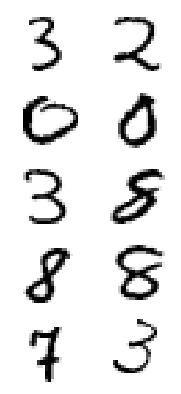

In [27]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap='binary', interpolation='nearest')
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap='binary', interpolation='nearest')
plt.axis('off')
plt.show()

In [ ]:
n_epochs = 100
batch_size = 500

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, 'Train loss:', loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, 'Test accuracy:', acc_test)

    save_path = saver.save(sess, './my_digit_comparison_model.ckpt')

Tarefa de classificação MNIST regular.

In [30]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_outputs = 10

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.compat.v1.placeholder(tf.int32, shape=(None), name='y')

dnn_outputs = dnn(X, name='DNN_A')
frozen_outputs = tf.compat.v1.stop_gradient(dnn_outputs)

logits = tf.compat.v1.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name='loss')

optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(y, logits, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.compat.v1.global_variables_initializer()

dnn_A_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='DNN_A')
restore_saver = tf.compat.v1.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.compat.v1.train.Saver()


n_epochs = 100
batch_size = 50

with tf.compat.v1.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_digit_comparison_model.ckpt')

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, 'Test accuracy:', acc_test)

    save_path = saver.save(sess, './my_mnist_model_final.ckpt')

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9372
10 Test accuracy: 0.9516
20 Test accuracy: 0.9656
30 Test accuracy: 0.9656
40 Test accuracy: 0.9656
50 Test accuracy: 0.9651
60 Test accuracy: 0.9649
70 Test accuracy: 0.9648
80 Test accuracy: 0.9646
90 Test accuracy: 0.9643
